<img src="images/dask_horizontal.svg" align="right" width="30%">

# Table of Contents
* [Grounding](#Grounding)
	* [Prelude](#Prelude)
		* [Example 1: simple word count](#Example-1:-simple-word-count)
		* [Example 2: background execution](#Example-2:-background-execution)
		* [Example 3: delayed execution](#Example-3:-delayed-execution)
	* [Dask is a graph execution engine](#Dask-is-a-graph-execution-engine)
		* [Exercise](#Exercise)


# Grounding

In this section, we will take you through some basic understanding of what dask is for, how it works, and some situations that it will be ideal for.

## Prelude

As python programmers, you probably already perform certain *tricks* to enable computation of larger-than-memory datasets, parallel execution or delayed/background execution. Perhaps with this phrasing, it is not clear what we mean, but a few examples should make things clearer. The point of dask is to make simple things easy and complex things possible!

### Example 1: simple word count

This directory contains a file called `Dockerfile`. How would you count the number of words in that file?

The simplest approach would be to load all the data into memory, split on whitespace and count the number of results. Here we use a regular expression to split words.

In [5]:
import re
splitter = re.compile('\w+')
with open('Dockerfile', 'r') as f:
    data = f.read()
result = len(splitter.findall(data))
result

129

The trouble with this approach is that it does not scale - if the file is very large, it, and the generated list of words, might fill up memory. We can easily avoid that, because we only need a simple sum, and each line is totally independent of the others. Now we evaluate each piece of data and immediately free up the space again, so we could perform this on arbitrarily-large files.

In [3]:
result = 0
with open('Dockerfile', 'r') as f:
    for line in f:
        result += len(splitter.findall(line))
result

129

### Example 2: background execution

There are many tasks that take a while to complete, but don't actually require much of the CPU, for example anything that requires communication over a network, or input from a user. In typical sequential programming, execution would need to halt while the process completes, and then continue execution. That would be dreadful for a user experience (imagine the slow progress bar that locks up the application and cannot be canceled), and wasteful of time (the CPU could have been doing useful work in the meantime.

For example, it may take time to calculate the disc usage of a person's home directory. We could launch it as a background task (linux/osx only for this syntax) from python:
```python
    import subprocess
    p = subprocess.Popen('du -sh ~', shell=True, stdout=subprocess.PIPE)
    p.returncode
```

The task is running in a separate process, and the return-code will remain `None` until it completes, when it will change to `0`. To get the result back, we need `print(p.communicate()[0].decode())` (which would block if the process was not complete).

In [19]:
import subprocess
p = subprocess.Popen('du -sh ~', shell=True, stdout=subprocess.PIPE)
p.returncode

Similarly, we can launch python processes and threads in the background. Some methods allow mapping over multiple inputs and gathering the results, more on that later.  

The thread starts and the cell completes immediately, but the data associated with the download only appears in the queue object some time later.

In [31]:
import threading
import queue
import urllib

def get_webdata(url, q):
    u = urllib.request.urlopen(url)
    q.put(u.read())

q = queue.Queue()
t = threading.Thread(target=get_webdata, args=('http://www.google.com', q))
t.start()

In [ ]:
# fetch result back into this thread. If the worker thread is not done, this would wait.
q.get()

### Example 3: delayed execution

There are many ways in python to specify the computation you want to execute, but only run it *later*.

In [54]:
def add(x, y):
    return x + y

# Sometimes we defer computations with strings
x = 15
y = 30
z = "add(x, y)"
eval(z)

45

In [55]:
# we can use lambda or other "closure"
x = 15
y = 30
z = lambda: add(x, y)
z()

45

In [40]:
# A very similar thing happens in functools.partial

import functools
z = functools.partial(add, x, y)
z()

45

In [41]:
# Python generators are delayed execution by default
# Many python functions expect such iterable objects

def gen():
    res = x
    yield res
    res += y
    yield y

g = gen()

In [44]:
# run once: we get one value and execution halts within the generator
# run again and the execution completes
next(g)

StopIteration: 

## Dask is a graph execution engine

Dask allows you to construct a prescription for the calculation you want to carry out. In the previous section, we saw that this idea is not as strange or unfamiliar as it may at first seem. Here is one way to do this:

In [46]:
import dask

@dask.delayed
def inc(x):
    return x + 1

@dask.delayed
def add(x, y):
    return x + y

Here we have used the delayed annotation to show that we want these functions to operate lazily - to save the set of inputs and execute only on demand. `dask.delayed` is also a function which can do this, without the annotation, leaving the original function unchanged, e.g., 
```python
    delayed_inc = dask.delayed(inc)
```

In [50]:
# this looks like ordinary code
incx = inc(15)
incy = inc(30)
total = add(incx, incy)
# incx, incy and total are all delayed objects. 
# They contain a prescription of how to execute
total.dask

{'add-03092b21-29d8-44f3-abde-19e62e4c7373': (<function __main__.add>,
  'inc-0911202f-3e9f-48e8-adf6-34271a216017',
  'inc-17b5ef13-5e50-4986-80c1-1a300d9e9a40'),
 'inc-0911202f-3e9f-48e8-adf6-34271a216017': (<function __main__.inc>, 15),
 'inc-17b5ef13-5e50-4986-80c1-1a300d9e9a40': (<function __main__.inc>, 30)}

We notice that calling a delayed function created a delayed object (incx, incy, total), equivalent to constructs like the `lambda`, above. Each holds a simple dictionary describing the task graph, a full specification of how to carry out the computation.

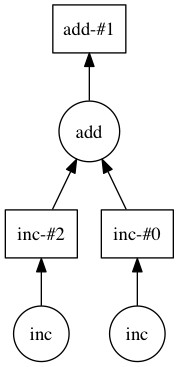

In [51]:
# in graph form
# circles are functions, rectangles are data/results
total.visualize()

In [52]:
# execute all tasks
total.compute()

47

**Why should you care about this?**

With `delayed` and normal pythonic looped code, very complex graphs can be built up and passed on to dask for execution. See a nice example of [simulated complex ETL](http://matthewrocklin.com/blog/work/2017/01/24/dask-custom) work flow.

With such a prescription of work to do, dask will intelligently execute it with care for minimizing the amount of data held in memory, while parallelizing over the tasks that make up a graph. Notice that in the following diagram, where four workers are processing the (simple) graph, execution progresses vertically up the branches first, so that intermediate results can be expunged before moving onto a new branch.

<img src="images/embarrassing.gif">

### Exercise

Consider reading three CSV files with `pd.read_csv` and then measuring their total length. We will consider how you would do this with ordinary python code, then build a graph for this process using delayed, and finally execute this graph using dask, for a handy speed-up factor of over two (there are only three inputs to parallelize over).

In [56]:
import pandas as pd
import os
filenames = [os.path.join('data', 'accounts.%d.csv' % i) for i in [0, 1, 2]]
filenames

['data/accounts.0.csv', 'data/accounts.1.csv', 'data/accounts.2.csv']

In [57]:
%%time

# normal, sequential code
a = pd.read_csv(filenames[0])
b = pd.read_csv(filenames[1])
c = pd.read_csv(filenames[2])

na = len(a)
nb = len(b)
nc = len(c)

total = sum([na, nb, nc])
total

CPU times: user 777 ms, sys: 109 ms, total: 886 ms
Wall time: 885 ms


Your task is to recreate this graph again using the delayed function on the original Python code. The three functions you want to delay are `pd.read_csv`, `len` and `sum`.. 

In [ ]:
from dask.multiprocessing import get

delayed_read_csv = delayed(pd.read_csv)
a = delayed_read_csv(filenames[0])
...

total = ...

# execute with multiprocessing scheduler
%time total.compute(get=get)   